# 4장 RNN

## 4.1 RNN 개요

### RNN (Reccurent Neural Network)

#### - RNN은 은닉층이 순환하는 구조

In [1]:
# 은닉층의 출력은 다음본 입력과 한께 은닉층의 입력이 된다.
# 은닉층이 이전 은닉층의 영향을 받기 때문에 신경망 자체도 이전 시점의 영향을 받음
# -> 과거의 기억을 이용해 판단함

In [2]:
# 자연어처럼 매번 입력값의 길이가 다른 데이터를 다룸
# -> 시계열데이터를 다룰 때 적용

In [3]:
# RNN은 역전파로 학습 가능
# 오차의 계산 방법은 일반적인 신경망과 다름
# -> 특정 시점에서 오차의 출력 기울기 = 출력층에서 역전파해 온 출력값의 기울기와 이후 시점에서 거슬러 온 출력기울기의 합

In [4]:
# RNN은 시계열 형태의 심층 신경망 구조로, 몇개의 층에 걸쳐 오차를 전파시키면 기울기 소실 & 발산 문제 발생
# 이전 시점에서 이어받은 데이터에 반복해서 같은 가중치를 곱하기 때문
# -> RNN층으로는 단기 기억은 유지되지만 장기 기억을 유지하기 어렵 = 장기 의존성 문제 발생
# -> 장기 의존성 문제 해결방안으로 LSTM, GRU가 있음

## 4.2 RNN층의 순전파

### 4.2.1 순전파의 개요

In [5]:
# 1. 현 시점의 입력에 가중치 행렬을 곱한 값
# 2. 직전 시점의 출력에 가중치 행렬을 곱한 값
# 3. 편향
# 4. 활성화 함수(1 + 2 + 3) 처리로 현 시점의 출력값으로 계산

### 4.2.2 순전파 수식

In [6]:
# 활성화 함수에 입력하기 전 값인 U(t) 행렬 원소를 보면
# 각 행은 배치 내의 샘플이고, 각 열은 해당 층에서의 뉴련을 표시
# ex) U12(t)는 배치내의 첫 번째 샘플, 층 내의 두번째 뉴런, 시점 t에서의 수치 값

### 4.2.3 순전파를 코드로 구현

In [2]:
import numpy as np

In [12]:
# x:입력  w:가중치  y_prev:이전 시점의 출력  v:가중치  b:편향  f:활성화함수
# u = np.dot(x, w) + np.dot(y_prev, v) + b
# y = np.tanh(u)

In [13]:
# tanh 는 기울기 소실 문제를 방지할 수 있다는 장점 때문에 RNN에서 활성화 함수로 흔히 쓰임

## 4.3 RNN층의 역전파

### 4.3.3 역전파를 코드로 구현

In [14]:
# x:입력  w:가중치  y_prev:이전 시점의 출력  v:가중치  delta:d의 행렬
# grad_w += np.dot(x.T, delta)        w의 기울기
# grad_v += np.dot(y_prev.T, delta)   v의 기울기
# grad_b += np.sum(delta, axis=0)     b의 기울기

# grad_x = np.dot(delta, w.T)
# grad_y_prev = np.dot(delta, v.T)

In [15]:
# W, V, B의 기울기는 모든 시점의 총합이므로 누적 합계를 위해 += 연산자 사용
# X, Y의 기울기는 모든 시점의 합을 구할 필요가 없기 때문에 = 연산자 사용

## 4.5 간단한 구조의 RNN 구현

### 4.5.1 훈련 데이터 생성

In [17]:
# RNN에 노이즈가 섞인 sin 곡선을 학습시키고 시계열 데이터를 예측

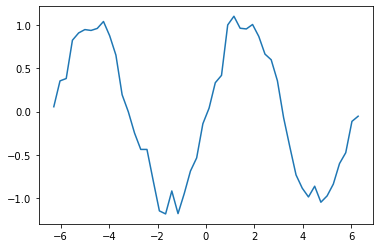

In [17]:
import matplotlib.pyplot as plt

n_time = 10   # 시점 수
n_in = 1      # 입력층 뉴런 수
n_mid = 20    # 은닉층 뉴런 수
n_out = 1     # 출력층 뉴런 수

eta = 0.001   # 학습률
epochs = 51
batch_size = 8
interval = 5  # 경과 표시 간격

# 훈련 데이터 생성
sin_x = np.linspace(-2*np.pi, 2*np.pi)  # -2ㅠ부터 2ㅠ까지
# sin 함수에 무작위로 노이즈 섞기
sin_y = np.sin(sin_x) + 0.1*np.random.randn(len(sin_x))
plt.plot(sin_x, sin_y)
plt.show()

### 4.5.2 데이터 전처리

In [18]:
n_sample = len(sin_x)-n_time   # 샘플 수
input_data = np.zeros((n_sample, n_time, n_in))   # 입력
correct_data = np.zeros((n_sample, n_out))        # 정답
for i in range(0, n_sample):
    input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
    correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 정답은 입력보다 한 시점 뒤

### 4.4.1 RNN층 클래스

In [46]:
# RNN 층
class SimpleRNNLayer:
    def __init__(self, n_upper, n):    # 파라미터 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)   # 자비에르 초기화 기반의 초깃값
        self.v = np.random.randn(n, n) / np.sqrt(n)
        self.b = np.zeros(n)
        
    def forward(self, x, y_prev):    # y_prev : 이전 시점의 출력
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)           # 출력
        
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)
        
        # 각 기울기
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)
        
        # 역전파 하기 전 누적된 기울기 모두 0으로 리셋
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

In [47]:
# 초기화를 위한 __init__메소드와 순전파 forward 메소드, 역전파 backward 메소드
# 누적 기울기를 0으로 리셋하는 reset_sum_grad 메소드, 파라미터를 갱신하는 update 메소드 구현

In [48]:
# __init__ 메소드에서 각 가중치를 자비에르 초깃값으로, 편향을 0으로 초기화시킴
# forward 메소드는 현 시점의 x와 y_prev를 인수로 받아 순전파 방법으로 처리
# forward 메소드는 시점만큼 반복하지만, y 값은 각 시점의 backward에서 사용하므로 외부에 저장
# backward 메소드는 x,y 등 현 시점의 각 값을 인수로 받음
# delta를 구한 다음, 이 값을 이용해 각 기울기 계산
# backward 메소드도 시점 수만큼 반복하는데 self.grad_w, self.grad_v, self.grad_b는 반복하는 동안 누적됨
# -> 역전파를 시작하기 전 reset_sum_grad메소드로 누적한 기울기를 모두 0으로 리셋시켜야함

In [49]:
# 전결합 출력층
class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u   # 항등함수
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

### 4.5.3 훈련

In [50]:
# 각 층의 초기화
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# 훈련
def train(x_mb, t_mb):
    # 순전파 RNN층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y
        
    # 순전파 출력층
    output_layer.forward(y)
    
    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    
    # 역전파 RNN층
    rnn_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y)
        grad_y = rnn_layer.grad_y_prev
        
        # 파라미터 갱신
        rnn_layer.update(eta)
        output_layer.update(eta)

In [51]:
# RNN에서 역전파할 때 순전파시점에서 출력등의 시계열 데이터를 미리 저장해둘 필요가 있음
# -> 메모리 절약을 위해 훈련과 예측 함수 따로 만듦

In [52]:
# 각 층을 초기화 시키고 RNN 모델을 학습시킴
# for문으로 RNN층의 순전파와 역전파를 시점의 수만큼 반복
# 시간은 거슬러 오르기 때문에 역전파의 반복방향은 순전파의 반대방향이 됨
# 순전파에서는 다음 시점의 출력 y, 역전파에서는 이전 시점의 출력 기울기 grad_y를 전파함
# 순전파에서 RNN층의 출력 y를 y_rnn에 시점 순으로 저장함
# 역전파 때는 같은 시점의 y 및 y_prev를 backward 메소드로 전달함
# -> RNN층에서 역전파할 때 해당 시점 근처의 값들 필요

### 4.5.4 예측

In [53]:
# train 함수와 동일하게 내부에서 순전파를 구현하지만, 출력값을 저장할 필요가 없기 때문에 코드가 짧음

In [54]:
# 예측
def predict(x_mb):
    # 순전파 RNN층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_prev = y
        
    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

Epoch:51/51 Error:0.2778498332864391


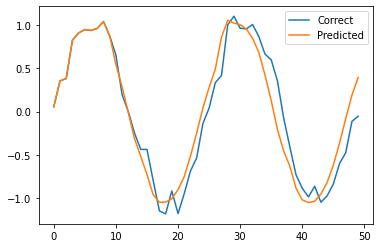

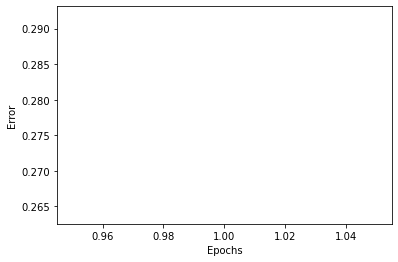

In [56]:
# 오차계산
def get_error(x, t):
    y = predict(x)
    return 1.0/2.0*np.sum(np.square(y - t))   # 오차제곱합

error_record = []
n_batch = len(input_data) // batch_size       # 1에포크당 배치 개수
for i in range(epochs):
    
    # 학습
    index_random = np.arange(len(input_data))
    np.random.shuffle(index_random)           # 인덱스 임의로 섞기
    for j in range(n_batch):
        
        # 미니 배치 데이터 훈련
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = input_data[mb_index, :]
        t_mb = correct_data[mb_index, :]
        train(x_mb, t_mb)
        
# 오차 구하기
error = get_error(input_data, correct_data)
error_record.append(error)

# 경과 표시
if i%interval == 0:
    print("Epoch:"+str(i+1)+"/"+str(epochs),
         "Error:"+str(error))
    predicted = input_data[0].reshape(-1).tolist()   # 최초입력
    for i in range(n_sample):
        x = np.array(predicted[-n_time:]).reshape(1,n_time, 1)
        y = predict(x)
        # 출력을 predicted에 추가하기
        predicted.append(float(y[0,0]))
        
    
    plt.plot(range(len(sin_y)), sin_y.tolist(), label="Correct")
    plt.plot(range(len(predicted)), predicted, label="Predicted")
    plt.legend()
    plt.show()
    
plt.plot(range(1, len(error_record)+1), error_record)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [ ]:
# 

## 4.6 2진수 덧셈 학습

### 4.6.2 2진수 준비

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# 각 설정값
n_time = 8       # 시점의 수(2진수의 자릿수)
n_in = 2         # 입력층 뉴런의 수
n_mid = 32       # 은닉층 뉴런의 수
n_out = 1        # 출력층 뉴런의 수

eta = 0.01       # 학습률
n_learn = 5001   # 학습 횟수
interval = 500   # 경과 표시 간격

# 2진수 생성
max_num = 2**n_time    # 10진수 최댓값
# 2진수를 저장하는 배열
binaries = np.zeros((max_num, n_time), dtype=int)
for i in range(max_num):
    num10 = i                           # 10진수 수
    for j in range(n_time):
        pow2 = 2 ** (n_time-1-j)        # 2의 거듭제곱
        binaries[i,j] = num10 // pow2   # 나눈 결과의 정수 부분만 저장
        num10 %= pow2                   # 나눈 몫을 다시 10진수에 저장
print(binaries)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]


In [62]:
# RNN층
class SimpleRNNLayer:
    def __init__(self, n_upper, n):
        # 파라미터 초깃값
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.v = np.random.randn(n, n) / np.sqrt(n)
        self.b = np.zeros(n)
        
    def forward(self, x, y_prev):  # y_prev : 이전 시점의 출력
        u = np.dot(x, self.w) + np.dot(y_prev, self.v) + self.b
        self.y = np.tanh(u)        # 출력
        
    def backward(self, x, y, y_prev, grad_y):
        delta = grad_y * (1 - y**2)
        
        # 각 기울기
        self.grad_w += np.dot(x.T, delta)
        self.grad_v += np.dot(y_prev.T, delta)
        self.grad_b += np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        self.grad_y_prev = np.dot(delta, self.v.T)
        
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        self.b -= eta * self.grad_b

### 4.6.3 출력층

In [63]:
# 전결합 출력층
class RNNOutputLayer:
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))    # 시그모이드 함수
        
    def backward(self, x, y, t):
        delta = (y-t) * y * (1-y)
        self.grad_w += np.dot(x.T, delta)
        self.grad_b += np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_b = np.zeros_like(self.b)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

In [64]:
# 모든 시점의 출력층 값을 사용하기 때문에 각 시점별 출력층 필요
# backward 메소드가 외부에서 현 시점의 x, y, t를 전달받음
# backward 메소드에서 가중치 기울기 grad_w와 편향 기울기 grad_b는 누적됨

In [65]:
# 활성화 함수에서는 해당 자릿수의 값을 0 ~ 1 로 예측하므로 시그모이드 함수 사용
# 오차 함수는 오차제곱합을 사용
# 입력 기울기 grad_x 는 앞 층의 RNN층으로 전파됨

### 4.6.4 훈련

In [60]:
# 각 층의 초기화
rnn_layer = SimpleRNNLayer(n_in, n_mid)
output_layer = RNNOutputLayer(n_mid, n_out)


# 훈련
def train(x_mb, t_mb):
    # 각 출력값을 저장하는 배열
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    y_out = np.zeros((len(x_mb), n_time, n_out))
    
    # 순전파
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        # RNN층
        x = x_mb[:, i, :]
        rnn_layer.forward(x, y_prev)
        y = rnn_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y
        
        # 출력층
        output_layer.forward(y)
        y_out[:, i, :] = output_layer.y
        
    # 역전파
    output_layer.reset_sum_grad()
    rnn_layer.reset_sum_grad()
    grad_y = 0
    for i in reversed(range(n_time)):
        # 출력층
        x = y_rnn[:, i+1, :]
        y = y_out[:, i, :]
        t = t_mb[:, i, :]
        output_layer.backward(x, y, t)
        grad_x_out = output_layer.grad_x
        
        # RNN층
        x = x_mb[:, i, :]
        y = y_rnn[:, i+1, :]
        y_prev = y_rnn[:, i, :]
        rnn_layer.backward(x, y, y_prev, grad_y+grad_x_out)
        grad_y = rnn_layer.grad_y_prev
        
    # 파라미터 갱신
    rnn_layer.update(eta)
    output_layer.update(eta)
    return y_out

# 오차 계산
def get_error(y, t):
    return 1.0/2.0*np.sum(np.square(y - t))  # 오차제곱합

for i in range(n_learn):
    # 무작위 10진수
    num1 = np.random.randint(max_num//2)
    num2 = np.random.randint(max_num//2)
    
    # 입력 데이터 생성
    x1 = binaries[num1]
    x2 = binaries[num2]
    x_in = np.zeros((1, n_time, n_in))
    x_in[0, :, 0] = x1
    x_in[0, :, 1] = x2
    x_in = np.flip(x_in, axis=1)             # 작은 자릿수를 과거 시점으로
    
    # 정답 데이터 준비
    t = binaries[num1+num2]
    t_in = t.reshape(1, n_time, n_out)
    t_in = np.flip(t_in, axis=1)
    
    # 훈련
    y_out = train(x_in, t_in)
    y = np.flip(y_out, axis=1).reshape(-1)
    
    # 오차 구하기
    error = get_error(y_out, t_in)
    
    # 경과 표시
    if i%interval == 0:
        y2 = np.where(y<0.5, 0, 1)  # 2진수 결과
        y10 = 0                     # 10진수 결과
        for j in range(len(y)):
            pow2 = 2 ** (n_time-1-j)  # 2의 거듭제곱
            y10 += y2[j] * pow2
            
        print("n_learn:", i)
        print("error:", error)
        print("output :", y2)
        print("correct:", t)
        
        c = "\(^_^)/ :" if (y2 == t).all() else "orz: "
        print(c + str(num1) + " + " + str(num2) + " = " + str(y10))
        print("-- -- -- -- -- -- -- -- -- -- -- -- -- -- --")
    
    

n_learn: 0
error: 0.9726639463067429
output : [0 0 1 0 0 0 1 1]
correct: [0 1 0 0 0 1 1 0]
orz: 32 + 38 = 35
-- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 500
error: 0.9849353411024301
output : [1 1 0 0 1 0 1 1]
correct: [1 1 0 0 0 0 1 0]
orz: 117 + 77 = 203
-- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 1000
error: 0.6728409908855167
output : [0 0 1 0 1 1 0 0]
correct: [0 1 1 0 1 1 0 0]
orz: 22 + 86 = 44
-- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 1500
error: 0.7800804834859074
output : [0 1 1 0 1 1 1 1]
correct: [0 1 0 0 1 0 1 1]
orz: 19 + 56 = 111
-- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 2000
error: 0.487009084683447
output : [0 0 1 1 0 1 0 0]
correct: [0 0 1 1 0 1 0 0]
\(^_^)/ :11 + 41 = 52
-- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 2500
error: 0.2836912589004077
output : [0 0 1 0 0 1 0 0]
correct: [0 1 1 0 0 1 0 0]
orz: 96 + 4 = 36
-- -- -- -- -- -- -- -- -- -- -- -- -- -- --
n_learn: 3000
error: 0.20032137324622779
output : [1 0 0 